In [1]:
%matplotlib inline

In [2]:
import  os
import  sys
import  glob

In [54]:
import  fitsio
import  redrock
import  redrock.templates

import  pandas                  as      pd
import  pylab                   as      pl
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits

from    astropy.table           import  Table, join, vstack
from    astropy.coordinates     import  SkyCoord
from    astropy                 import  units as u
from    desitarget.cmx          import  cmx_targetmask
from    desitarget              import  targetmask
from    desispec.interpolation  import  resample_flux
from    desispec.resolution     import  Resolution
from    desispec.specscore      import  compute_frame_scores
from    collections             import  OrderedDict
from    mpl_toolkits.axes_grid1 import make_axes_locatable


In [4]:
##  DR7 cutouts
import  requests

from    PIL                    import  Image
from    io                     import  BytesIO

In [6]:
# Prospect
sys.path.append("/global/homes/m/mjwilson/BGS/MINISV/prospect/py/")

import desispec
import prospect

from   prospect                import utils_specviewer, plotframes

In [7]:
plt.rcParams['figure.figsize'] = [10, 10]

##  DR7 cutouts 

In [8]:
def get_dr7cutout(ra, dec):
  nim         = len(ra)
  nrow        =  np.maximum(np.floor(nim / 5).astype(np.int), 1)

  fig, axes   = plt.subplots(nrow, 5, figsize=(20, 5 * nrow))

  row         = 0
  col         = 0

  nmax        = np.minimum(5 * nrow, nim)
  
  for i in range(nmax):        
    url       = 'http://legacysurvey.org/viewer/jpeg-cutout?ra={:.4f}&dec={:.4f}&layer=decals-dr7&pixscale=0.27&bands=grz'.format(ra[i], dec[i])
    response  = requests.get(url)
    img       = Image.open(BytesIO(response.content))

    axes[row, col].imshow(img)
    
    col      += 1
    
    if col > 4:
        row  += 1
        col   = 0 

##  Night log.
http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2020-02-25/nightsum.html

##  Mini SV page.
https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

#  Summary 

In [9]:
# /global/homes/m/mjwilson/BGS/MINISV/zhou
root  = '/global/cscratch1/sd/mjwilson/BGS/MINISV/coadds/'

## Prep. redrock templates

In [10]:
templates = dict()

for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


## GET GAMA G12 TRUTH TABLES

In [11]:
GAMA  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/GAMA-DR3-SpecObj-match.fits')
LGAMA = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-GAMA-DR3-SpecObj-match.fits')

In [12]:
# Table(LGAMA)

In [13]:
# Table(GAMA)

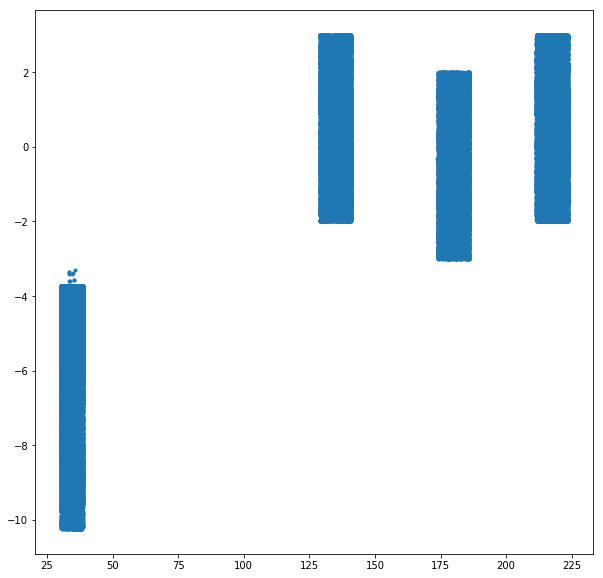

In [14]:
plt.rcParams['figure.figsize'] = [10, 10]

pl.plot(GAMA['RA'], GAMA['DEC'], '.')

In [15]:
##  Restrict to G12
isin   = (GAMA['RA'] < 200.) & (GAMA['RA'] > 150.)

G12    =  GAMA[isin]
LG12   =  LGAMA[isin]

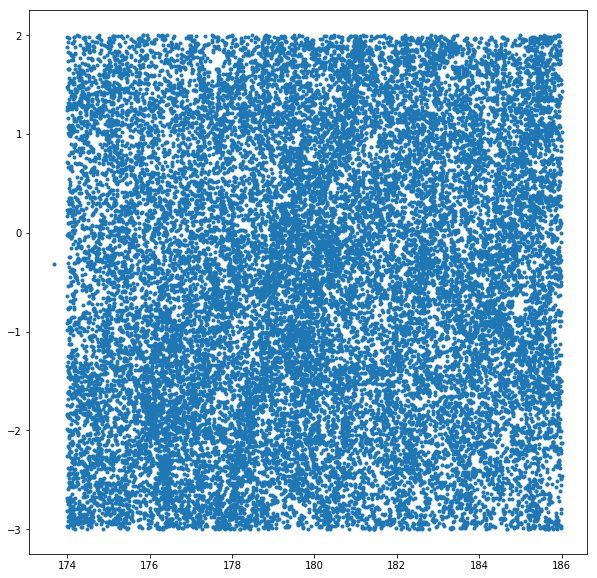

In [16]:
plt.rcParams['figure.figsize'] = [10, 10]

pl.plot(G12['RA'], G12['DEC'], '.')

##  GET SDSS redshifts  

In [17]:
SDSS  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/sdss-specObj-dr14-unique-trimmed-match.fits')
LSDSS = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-sdss-specObj-dr14-unique-trimmed-match.fits')

##  Rongpu cframe Table 

In [18]:
# ALL EXPIDS
cframes    = Table(fits.open('/global/homes/m/mjwilson/BGS/MINISV/zhou/bgs_allcframes.fits')[1].data)
del cframes['cframe']

# max_width=-1, max_lines=-1.
cframes['night', 'mjd', 'lat', 'lon', 'elv', 'tileid', 'expid', 'exptime', 'camera'].pprint(max_width=-1)
print('\n\n')
cframes['petal_loc', 'ra', 'dec', 'MOONALT', 'MOONRA', 'MOONDEC', 'MOONFRAC', 'MOONSEP'].pprint(max_width=-1)
print('\n\n')
cframes['SUNALT', 'SUNRA', 'SUNDEC', 'SUNSEP'].pprint(max_width=-1)

 night        mjd         lat       lon      elv   tileid expid exptime camera
-------- -------------- -------- ---------- ------ ------ ----- ------- ------
20200303 58912.31315446 31.96403 -111.59989 2097.0  70500 52937   500.0      r
20200228 58908.18319769 31.96403 -111.59989 2097.0  70500 52630   500.0      z
20200228 58908.18319769 31.96403 -111.59989 2097.0  70500 52630   500.0      r
20200303 58912.34548426 31.96403 -111.59989 2097.0  70500 52941   500.0      z
20200228 58908.18319769 31.96403 -111.59989 2097.0  70500 52630   500.0      b
20200303 58912.29681766 31.96403 -111.59989 2097.0  70500 52935   500.0      b
20200303 58912.34548426 31.96403 -111.59989 2097.0  70500 52941   500.0      r
20200303 58912.29681766 31.96403 -111.59989 2097.0  70500 52935   500.0      r
20200303 58912.29681766 31.96403 -111.59989 2097.0  70500 52935   500.0      z
20200303 58912.34548426 31.96403 -111.59989 2097.0  70500 52941   500.0      b
     ...            ...      ...        ...    ...  

In [19]:
# cframes    = cframes[cframes['night'] == '20200229']
# cframes

In [20]:
# BGS EXPIDS
bgs_expids = cframes['expid']
nights     = cframes['night'] 
tiles      = cframes['tileid']
petals     = cframes['petal_loc']

##  Unique tiles and nights.

In [21]:
samples    = OrderedDict(set(zip(nights, tiles)))
order      = np.sort([np.int(x) for x in samples.keys()]).astype(str)

samples    = OrderedDict(zip(order, [samples[x] for x in order]))
samples    = list(zip(samples.keys(), samples.values()))
samples

[('20200225', 70502),
 ('20200227', 70502),
 ('20200228', 70500),
 ('20200303', 70500)]

##  GET COORDINATES FILE FOR FIBER REACH ERRORS
https://desi.lbl.gov/trac/wiki/FPS/PositionerFlags

##  Missing coordinates files 

##  NUMBER OF FIBER REACH ERRORS FOR ALL TARGETS ON PLATE

##   GET COADDED EXPOSURES AND ZBEST FILES

In [22]:
# XTENSION= 'IMAGE   '           / Image extension                                
# BITPIX  =                  -32 / array data type                                
# NAXIS   =                    2 / number of array dimensions                     
# NAXIS1  =                 7781                                                  
# NAXIS2  =                  500                                                  
# PCOUNT  =                    0 / number of parameters                           
# GCOUNT  =                    1 / number of groups                               
# EXTNAME = 'BRZ_FLUX'           / extension name                                 
# BUNIT   = '10**-17 erg/(s cm2 Angstrom)'                                        
# CHECKSUM= '1gAq4f6n1fAn1f3n'   / HDU checksum updated 2020-02-26T06:51:09       
# DATASUM = '1442897442'         / data unit checksum updated 2020-02-26T06:51:09 

In [23]:
# XTENSION= 'IMAGE   '           / Image extension                                
# BITPIX  =                  -32 / array data type                                
# NAXIS   =                    2 / number of array dimensions                     
# NAXIS1  =                 7781                                                  
# NAXIS2  =                  500                                                  
# PCOUNT  =                    0 / number of parameters                           
# GCOUNT  =                    1 / number of groups                               
# EXTNAME = 'BRZ_IVAR'           / extension name                                 
# BUNIT   = '10**+34 (s2 cm4 Angstrom2) / erg2'                                   
# CHECKSUM= '4aSk6XPj4aPj4WPj'   / HDU checksum updated 2020-02-26T06:51:09       
# DATASUM = '966772586'          / data unit checksum updated 2020-02-26T06:51:09 

In [24]:
utiles                     = np.unique(tiles)
upetals                    = np.unique(petals)
unights                    = np.unique(nights)

In [51]:
fpath                      = root + '/NEXP1/{}/{}/coadd-{}-6-{:08d}.fits'.format(70500, '20200303', '20200303', 52933)
wave                       = fitsio.read(fpath, ext=2)

In [57]:
fpath                      = root + '/NEXP1/{}/{}/coadd-{}-6-{:08d}.fits'.format(70500, '20200303', '20200303', 52933)
scores                     = fits.open(fpath)[7]
scores.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   72 / length of dimension 1                          
NAXIS2  =                  500 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    9 / number of table fields                         
TTYPE1  = 'INTEG_COADD_FLUX_B' / integ. flux in wave. range 4000,5800A          
TFORM1  = 'D       '                                                            
TTYPE2  = 'MEDIAN_COADD_FLUX_B' / median flux in wave. range 4000,5800A         
TFORM2  = 'D       '                                                            
TTYPE3  = 'MEDIAN_COADD_SNR_

In [58]:
bandpasses                 = {"b": [4000, 5800], "r": [5800, 7600], "z": [7600, 9800]}

fpath                      = root + '/NEXP1/{}/{}/coadd-{}-6-{:08d}.fits'.format(70500, '20200303', '20200303', 52933)
wave                       = fitsio.read(fpath, ext=2)

results                    = OrderedDict()

for tile in utiles:
    results[tile]          = OrderedDict()

for i, (night, tile) in enumerate(samples):
      results[tile][night] = OrderedDict()

      ##  1 
      for ncoadd in [2, 4, 'ALL']:
        ##  E.g. coadd-20200303-6-2expc.fits
        ##       coadd-20200303-3-00052933.fits 
        ##
        ##       coadd-20200303-6-3exp-subset-2.fits
        if ncoadd in [2, 4]:
          look               = glob.glob(root + '/NEXP{}/{}/{}/coadd-*'.format(ncoadd, tile, night)) 
          subsets            = [x.split('-')[-1].replace('.fits', '') for x in look]
          subsets            = np.array([int(x) for x in subsets])                
   
          try:
            maxn_splits      = subsets.max()

          except:
            print('No coadd available for tile {} night {} and ncoadd {} ({})'.format(tile, night, ncoadd, subsets))

            key                                    = 'NEXP' + str(ncoadd)
            
            results[tile][night][key]              = None
          
            continue
     
          keys                                     = ['NEXP' + str(ncoadd) + '-' + str(nsplit) for nsplit in range(maxn_splits)]      
          nsplits                                  =  list(range(maxn_splits))
    
        elif ncoadd == 'ALL':
          keys                                     = ['ALL']
          nsplits                                  = [-99]

        else:
          raise  ValueError('Problem.')
                 
        for key, nsplit in zip(keys, nsplits): 
          results[tile][night][key]                = {}
         
          _                                        = cframes[(cframes['night'] == night) & (cframes['tileid'] == tile)]
    
          for attribute in ['ra', 'dec', 'exptime', 'MOONFRAC', 'MOONALT', 'MOONSEP']: 
            results[tile][night][key][attribute.upper()]   = np.float(np.mean(_[attribute]))
        
          results[tile][night][key]['coadds']       = []
          results[tile][night][key]['coadds_flux']  = []
          results[tile][night][key]['coadds_ivar']  = []
          results[tile][night][key]['coadds_mask']  = []
          results[tile][night][key]['coadds_res']   = []
          results[tile][night][key]['zbests']       = []
                
          results[tile][night][key]['scores']       = []
            
          results[tile][night][key]['coadds_paths'] = {}
          results[tile][night][key]['zbests_paths'] = {}
          
          for petal in upetals:
            print('Solving for tile {}, night {}, petal {} and ncoadd {}.'.format(tile, night, petal, ncoadd))
            
            if key == 'ALL':
              ##  FIRST EXT: FIBER MAPS
              coadd_path = root + '/ALL/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal) 
              zbest_path = root + '/ALL/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal).replace('coadd', 'zbest')
            
            else:
              ##  FIRST EXT: FIBER MAPS
              coadd_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{}exp-subset-{}.fits'.format(ncoadd, tile, night, night, petal, ncoadd, nsplit) 
              zbest_path = root + '/NEXP{}/{}/{}/coadd-{}-{}-{}exp-subset-{}.fits'.format(ncoadd, tile, night, night, petal, ncoadd, nsplit).replace('coadd', 'zbest')
            
            results[tile][night][key]['coadds_paths'][petal] = coadd_path
            results[tile][night][key]['zbests_paths'][petal] = zbest_path
            
            results[tile][night][key]['coadds'].append(fitsio.read(coadd_path))  
            results[tile][night][key]['zbests'].append(fitsio.read(zbest_path))
    
            _                   = fitsio.read(coadd_path, ext=2) 
         
            assert  np.all(np.isclose(wave, _))
        
            results[tile][night][key]['coadds_flux'].append(fitsio.read(coadd_path, ext=3)) 
            results[tile][night][key]['coadds_ivar'].append(fitsio.read(coadd_path, ext=4))
            results[tile][night][key]['coadds_mask'].append(fitsio.read(coadd_path, ext=5))
            results[tile][night][key]['coadds_res'].append(fitsio.read(coadd_path,  ext=6))
            
            results[tile][night][key]['scores'].append(fitsio.read(coadd_path,  ext=7))

          ##
          results[tile][night][key]['coadds']      = np.hstack(results[tile][night][key]['coadds'])
          results[tile][night][key]['zbests']      = np.hstack(results[tile][night][key]['zbests'])
          results[tile][night][key]['coadds_flux'] = np.vstack(results[tile][night][key]['coadds_flux'])
          results[tile][night][key]['coadds_ivar'] = np.vstack(results[tile][night][key]['coadds_ivar'])
          results[tile][night][key]['coadds_mask'] = np.vstack(results[tile][night][key]['coadds_mask']) 
          results[tile][night][key]['coadds_res']  = np.vstack(results[tile][night][key]['coadds_res'])
        
          results[tile][night][key]['scores']      = np.vstack(results[tile][night][key]['scores'])
    
          ##  for key in ['coadds', 'zbests', 'coadds_flux', 'coadds_ivar', 'coadds_mask', 'coadds_res']:
          ##    print(results[tile][night][key].shape)

Solving for tile 70502, night 20200225, petal 0 and ncoadd 2.
Solving for tile 70502, night 20200225, petal 3 and ncoadd 2.
Solving for tile 70502, night 20200225, petal 6 and ncoadd 2.
Solving for tile 70502, night 20200225, petal 7 and ncoadd 2.
Solving for tile 70502, night 20200225, petal 9 and ncoadd 2.
Solving for tile 70502, night 20200225, petal 0 and ncoadd 2.
Solving for tile 70502, night 20200225, petal 3 and ncoadd 2.
Solving for tile 70502, night 20200225, petal 6 and ncoadd 2.
Solving for tile 70502, night 20200225, petal 7 and ncoadd 2.
Solving for tile 70502, night 20200225, petal 9 and ncoadd 2.
Solving for tile 70502, night 20200225, petal 0 and ncoadd ALL.
Solving for tile 70502, night 20200225, petal 3 and ncoadd ALL.
Solving for tile 70502, night 20200225, petal 6 and ncoadd ALL.
Solving for tile 70502, night 20200225, petal 7 and ncoadd ALL.
Solving for tile 70502, night 20200225, petal 9 and ncoadd ALL.
No coadd available for tile 70502 night 20200227 and ncoadd 

In [ ]:
# results[utiles[0]][unights[0]]['zbests'].dtype.names

In [26]:
for i, (night, tile) in enumerate(samples):
    keys = results[tile][night].keys()

    print(night, tile, keys)

20200225 70502 odict_keys(['NEXP2-0', 'NEXP2-1', 'ALL'])
20200227 70502 odict_keys(['NEXP4', 'ALL'])
20200228 70500 odict_keys(['NEXP4', 'ALL'])
20200303 70500 odict_keys(['NEXP2-0', 'NEXP2-1', 'NEXP2-2', 'NEXP2-3', 'NEXP2-4', 'NEXP4-0', 'NEXP4-1', 'ALL'])


##  N BGS TARGETS, WITH NO FIBER ERROR, AND GOOD Z, OF TYPE MAIN BRIGHT, OF TYPE SV0

In [107]:
print('\n\nNIGHT\t\tTILE\tKEY\t\tEXPTIME\t\tMOONFRAC\tMOONALT\t\tIS_BGS\t\tZGOOD_BGS\tMAIN')

for i, (night, tile) in enumerate(samples):
  keys = results[tile][night].keys()
    
  for key in keys:
    if results[tile][night][key] is None:
        continue
    
    # No fiber reach flags available.
    isgood         = np.ones_like(results[tile][night][key]['coadds']['CMX_TARGET'])
        
    IS_MSV_BRIGHT  = (results[tile][night][key]['coadds']['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0
    IS_SV0         = (results[tile][night][key]['coadds']['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0

    IS_BGS         = IS_MSV_BRIGHT | IS_SV0 
    IS_GOOD_BGS    = IS_BGS & isgood

    IS_GOOD_BGS    = IS_GOOD_BGS.astype(bool)
    
    IS_ZGOOD_BGS   =  IS_GOOD_BGS & (results[tile][night][key]['zbests']['ZWARN'] == 0) & (results[tile][night][key]['zbests']['SPECTYPE'] == b'GALAXY')
    IS_ZGOOD_BGS   = IS_ZGOOD_BGS & (results[tile][night][key]['zbests']['ZERR']   < 0.0005 * (1. + results[tile][night][key]['zbests']['Z']))
    
    IS_MSV_BRIGHT  = IS_MSV_BRIGHT[IS_ZGOOD_BGS]
    IS_SV0         =        IS_SV0[IS_ZGOOD_BGS]
    
    # results[tile][night][key]['NEXP'];
    print('{}\t{}\t{}\t\t{:.2f}\t\t{:.2f}\t\t{:+.2f}\t\t{}\t\t{}\t\t{}\t'.format(night,\
                                                                        tile,\
                                                                        key,\
                                                                        results[tile][night][key]['EXPTIME'],\
                                                                        results[tile][night][key]['MOONFRAC'],\
                                                                        results[tile][night][key]['MOONALT'],\
                                                                        np.count_nonzero(IS_BGS),\
                                                                        np.count_nonzero(IS_ZGOOD_BGS),\
                                                                        np.count_nonzero(IS_MSV_BRIGHT)))
    
    results[tile][night][key]['IS_BGS']       = IS_BGS
    results[tile][night][key]['IS_ZGOOD_BGS'] = IS_ZGOOD_BGS



NIGHT		TILE	KEY		EXPTIME		MOONFRAC	MOONALT		IS_BGS		ZGOOD_BGS	MAIN
20200225	70502	NEXP2-0		900.00		0.07		-48.66		1484		1254		756	
20200225	70502	NEXP2-1		900.00		0.07		-48.66		1484		1255		752	
20200225	70502	ALL		900.00		0.07		-48.66		1484		1318		778	
20200227	70502	ALL		500.00		0.19		-44.28		1486		618		398	
20200228	70500	ALL		500.00		0.26		+11.26		1302		470		268	
20200303	70500	NEXP2-0		500.00		0.65		+24.66		1302		953		560	
20200303	70500	NEXP2-1		500.00		0.65		+24.66		1302		924		539	
20200303	70500	NEXP2-2		500.00		0.65		+24.66		1302		930		539	
20200303	70500	NEXP2-3		500.00		0.65		+24.66		1302		943		554	
20200303	70500	NEXP2-4		500.00		0.65		+24.66		1302		951		556	
20200303	70500	NEXP4-0		500.00		0.65		+24.66		1302		990		569	
20200303	70500	NEXP4-1		500.00		0.65		+24.66		1302		982		564	
20200303	70500	ALL		500.00		0.65		+24.66		1302		1018		583	


## Keep Tiles for which we have NEXP of 2, 4 and ALL.

In [108]:
tile          = 70500
night         = '20200303'

In [109]:
keep          = results[tile][night]

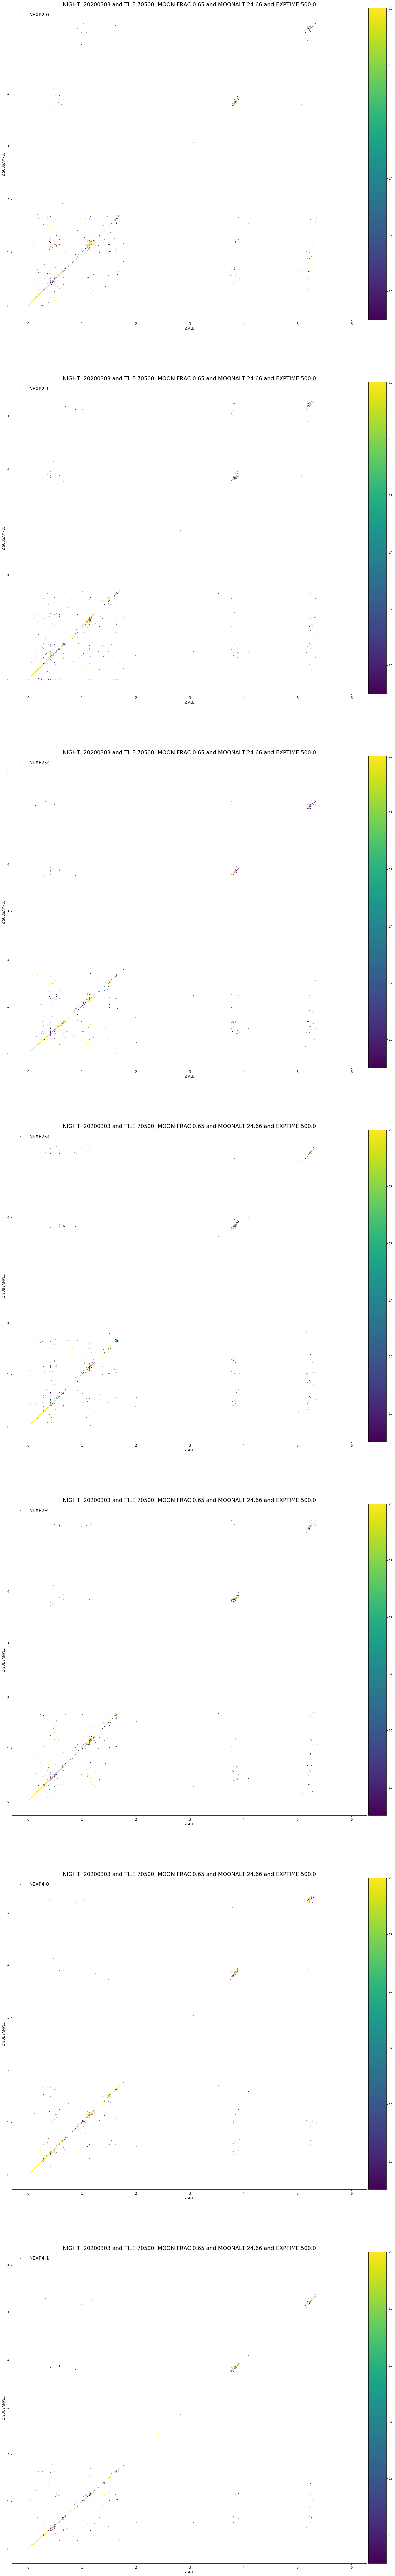

In [110]:
keys          = ['NEXP2-0', 'NEXP2-1', 'NEXP2-2', 'NEXP2-3', 'NEXP2-4', 'NEXP4-0', 'NEXP4-1']

fig, axes     = plt.subplots(len(keys), figsize=(20, len(keys) * 20))

for i, key in enumerate(keys):
    assert   np.all(keep['ALL']['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])
    
    im        = axes[i].scatter(keep['ALL']['zbests']['Z'], keep[key]['zbests']['Z'], c=keep[key]['zbests']['DELTACHI2'], label=key, marker='.', lw=0, s=10, vmin=9., vmax=20.)
    
    moonfrac  = results[tile][night][key]['MOONFRAC']
    moonalt   = results[tile][night][key]['MOONALT']
    exptime   = results[tile][night][key]['EXPTIME']

    divider   = make_axes_locatable(axes[i])
    cax       = divider.append_axes('right', size='5%', pad=0.05)

    fig.colorbar(im, cax=cax, orientation='vertical')
    
    axes[i].set_xlabel('Z ALL')
    axes[i].set_ylabel('Z SUBSAMPLE')
    
    # axes[i].set_xscale('log')
    # axes[i].set_yscale('log')
    
    axes[i].legend(frameon=False, loc=2, ncol=4, fontsize=14)

    axes[i].set_title('NIGHT: {} and TILE {}; MOON FRAC {:.2f} and MOONALT {:.2f} and EXPTIME {:.1f}'.format(night, tile, moonfrac, moonalt, exptime), fontsize=16)

In [40]:
for key in keep.keys():
  zbest                       = keep[key]['zbests']
  coadds                      = keep[key]['coadds']

  # Keep ALL good such that targets are common across keys.
  is_zgood_bgs                = keep['ALL']['IS_ZGOOD_BGS']
    
  coadds_paths                = keep[key]['coadds_paths']

  zbest                       = Table(zbest)

  targetids                   = zbest['TARGETID']

  for petal in upetals:
    print('Generating key {} and petal {}.'.format(key, petal))
    
    specfile                  = coadds_paths[petal]
    
    spectra                   = desispec.io.read_spectra(specfile)
    spectra.fibermap["NIGHT"] = np.ones(len(spectra.fibermap))
    
    in_petal                  = is_zgood_bgs & (coadds['PETAL_LOC'] == petal)
    in_petal                  = targetids[in_petal]
    in_petal20                = in_petal[:70]
    
    sp_single_exp             = spectra.select(targets=in_petal20)

    plotframes.plotspectra(sp_single_exp, zcatalog=zbest, notebook=False, with_coaddcam=False, with_thumb_tab=False, title='{}_{}_'.format(tile, night) + key + '_' + str(petal), html_dir='/global/homes/m/mjwilson/www/MINISV')

Generating key NEXP2-0 and petal 0.
Generating key NEXP2-0 and petal 3.
Generating key NEXP2-0 and petal 6.
Generating key NEXP2-0 and petal 7.
Generating key NEXP2-0 and petal 9.
Generating key NEXP2-1 and petal 0.
Generating key NEXP2-1 and petal 3.
Generating key NEXP2-1 and petal 6.
Generating key NEXP2-1 and petal 7.
Generating key NEXP2-1 and petal 9.
Generating key NEXP2-2 and petal 0.
Generating key NEXP2-2 and petal 3.
Generating key NEXP2-2 and petal 6.
Generating key NEXP2-2 and petal 7.
Generating key NEXP2-2 and petal 9.
Generating key NEXP2-3 and petal 0.
Generating key NEXP2-3 and petal 3.
Generating key NEXP2-3 and petal 6.
Generating key NEXP2-3 and petal 7.
Generating key NEXP2-3 and petal 9.
Generating key NEXP2-4 and petal 0.
Generating key NEXP2-4 and petal 3.
Generating key NEXP2-4 and petal 6.
Generating key NEXP2-4 and petal 7.
Generating key NEXP2-4 and petal 9.
Generating key NEXP4-0 and petal 0.
Generating key NEXP4-0 and petal 3.
Generating key NEXP4-0 and p

##  Failures

In [41]:
for key in keep.keys():
  zbest                       = keep[key]['zbests']
  coadds                      = keep[key]['coadds']
    
  fails                       = keep[key]['zbests']['ZWARN'] > 0  

  # Keep ALL good such that targets are common across keys.
  is_bgs                      = keep['ALL']['IS_BGS']
    
  coadds_paths                = keep[key]['coadds_paths']

  zbest                       = Table(zbest)

  targetids                   = zbest['TARGETID']

  for petal in upetals:
    print('Generating key {} and petal {}.'.format(key, petal))
    
    specfile                  = coadds_paths[petal]
    
    spectra                   = desispec.io.read_spectra(specfile)
    spectra.fibermap["NIGHT"] = np.ones(len(spectra.fibermap))
    
    in_petal                  = is_bgs & fails & (coadds['PETAL_LOC'] == petal)
    in_petal                  = targetids[in_petal]
    in_petal20                = in_petal[:70]
    
    sp_single_exp             = spectra.select(targets=in_petal20)

    plotframes.plotspectra(sp_single_exp, zcatalog=zbest, notebook=False, with_coaddcam=False, with_thumb_tab=False, title='{}_{}_'.format(tile, night) + key + '_' + str(petal) + '_FAILURES', html_dir='/global/homes/m/mjwilson/www/MINISV')

Generating key NEXP2-0 and petal 0.
Generating key NEXP2-0 and petal 3.
Generating key NEXP2-0 and petal 6.
Generating key NEXP2-0 and petal 7.
Generating key NEXP2-0 and petal 9.
Generating key NEXP2-1 and petal 0.
Generating key NEXP2-1 and petal 3.
Generating key NEXP2-1 and petal 6.
Generating key NEXP2-1 and petal 7.
Generating key NEXP2-1 and petal 9.
Generating key NEXP2-2 and petal 0.
Generating key NEXP2-2 and petal 3.
Generating key NEXP2-2 and petal 6.
Generating key NEXP2-2 and petal 7.


/global/homes/m/mjwilson/BGS/MINISV/prospect/py/prospect/plotframes.py:405: RuntimeWarning: All-NaN slice encountered
  ymin = min(ymin, np.nanmin(spectra.flux[band][0]))
/global/homes/m/mjwilson/BGS/MINISV/prospect/py/prospect/plotframes.py:406: RuntimeWarning: All-NaN slice encountered
  ymax = max(ymax, np.nanmax(spectra.flux[band][0]))


Generating key NEXP2-2 and petal 9.
Generating key NEXP2-3 and petal 0.
Generating key NEXP2-3 and petal 3.
Generating key NEXP2-3 and petal 6.
Generating key NEXP2-3 and petal 7.
Generating key NEXP2-3 and petal 9.
Generating key NEXP2-4 and petal 0.
Generating key NEXP2-4 and petal 3.
Generating key NEXP2-4 and petal 6.
Generating key NEXP2-4 and petal 7.
Generating key NEXP2-4 and petal 9.
Generating key NEXP4-0 and petal 0.
Generating key NEXP4-0 and petal 3.
Generating key NEXP4-0 and petal 6.
Generating key NEXP4-0 and petal 7.
Generating key NEXP4-0 and petal 9.
Generating key NEXP4-1 and petal 0.
Generating key NEXP4-1 and petal 3.
Generating key NEXP4-1 and petal 6.
Generating key NEXP4-1 and petal 7.
Generating key NEXP4-1 and petal 9.
Generating key ALL and petal 0.
Generating key ALL and petal 3.
Generating key ALL and petal 6.
Generating key ALL and petal 7.
Generating key ALL and petal 9.


In [44]:
#  Fix permissions.
os.system('chmod --reference=/global/homes/m/mjwilson/www/plots/visibility-nofullmoon-26-0.pdf /global/homes/m/mjwilson/www/MINISV/*')

0

##  Example of coadded flux

In [ ]:
def bestfit_compare(i, ax, zbests, coadds_flux):    
    zbest    = Table(zbests)[i]
    
    z        = zbest['Z']
    zerr     = zbest['ZERR']
    dchi2    = zbest['DELTACHI2']
    zwarn    = zbest['ZWARN']
    targetid = zbest['TARGETID']
    spectype = zbest['SPECTYPE'].strip()
    subtype  = zbest['SUBTYPE'].strip()
    
    fulltype = (spectype, subtype)
    
    # print(z, zerr)

    ncoeff   = templates[fulltype].flux.shape[0]
    coeff    = zbest['COEFF'][0:ncoeff]

    tflux    = templates[fulltype].flux.T.dot(coeff)
    twave    = templates[fulltype].wave * (1. + z)

    # R      = Resolution(res)
    # txflux = R.dot(resample_flux(wave, twave, tflux))
    
    ax.plot(wave, coadds_flux[i,:], lw=1.0, label='z: {} +- {} (ZWARN == {}, SPECTYPE={}, SUBTYPE={}, $\Delta \chi^2$ = {})'.format(z, zerr, zwarn, spectype, subtype, dchi2))
    ax.plot(twave + 5.,            tflux, lw=1.0)
    # ax.plot( wave,              txflux, lw=1.0)

    ax.legend(loc=2, frameon=False)
    
    ax.set_xlim(3500., 10000.)
    ax.set_ylim(bottom = -2.5)

##  Seems early days for this test, but there we go.

In [111]:
keep['ALL']['zbests']['Z'].shape
keep['NEXP2-0']['zbests']['Z'].shape

(2500,)

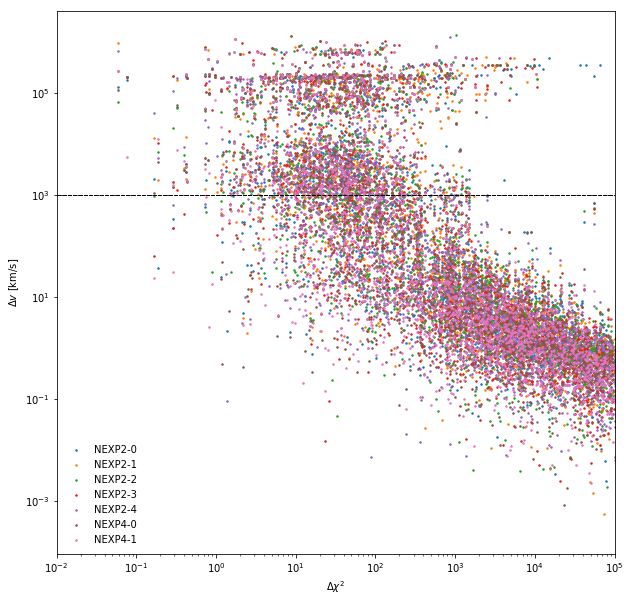

In [112]:
keys              = ['NEXP2-0', 'NEXP2-1', 'NEXP2-2', 'NEXP2-3', 'NEXP2-4', 'NEXP4-0', 'NEXP4-1']
fig, axes         = plt.subplots(1, figsize=(10, 10))

for i, key in enumerate(keys):
    assert   np.all(keep['ALL']['zbests']['TARGETID'] == keep[key]['zbests']['TARGETID'])

    isgood        = keep['ALL']['IS_ZGOOD_BGS']
    
    delta_v       = 3.e5 * (keep['ALL']['zbests']['Z'] - keep[key]['zbests']['Z']) / (1. + keep['ALL']['zbests']['Z'])
    
    # cat_fail      = (delta_v > 1.e3) & isgood
    # cat_fail_frac = np.count_nonzero(cat_fail) / np.count_nonzero(isgood)
   
    pl.loglog(keep['ALL']['zbests']['DELTACHI2'], np.abs(delta_v), marker='.', label=key, lw=0, markersize=3)

    pl.axhline(1.e3, xmin=0., xmax=1., linestyle='--', c='k', lw=1)
    
    pl.xlim(1.e-2, 1.e5)

    pl.xlabel(r'$\Delta \chi^2$')
    pl.ylabel(r'$\Delta v \ [\rm{km}/s]$')
    
pl.legend(frameon=False)

##  Done.